# ASSIGNMENT 2 QUESTION 3 COMPUTATIONAL FINANCE

PART A: Data retrieval:

In [64]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
import numpy as np


In [8]:
# Set up the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [9]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    # Amsterdam area (you can change)
    "latitude": 52.37,
    "longitude": 4.89,
    "start_date": "2020-08-10",
    "end_date": "2024-08-23",
    "hourly": "temperature_2m",
    "daily": "temperature_2m_mean"
}

responses = openmeteo.weather_api(url, params=params)

In [11]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Elevation {response.Elevation()} masl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Elevation 11.0 masl
Timezone None None
Timezone difference to GMT+0 0 s


In [34]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature = hourly.Variables(0).ValuesAsNumpy()
hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )
}
hourly_data["temperature_2m"] = hourly_temperature
hourly_dataframe = pd.DataFrame(data=hourly_data)
#print(hourly_dataframe)

In [33]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature = daily.Variables(0).ValuesAsNumpy()
daily_data = {
    "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )
}
daily_data["temperature_2m_mean"] = daily_temperature
daily_dataframe = pd.DataFrame(data=daily_data)
daily_dataframe = daily_dataframe.set_index(pd.to_datetime(daily_dataframe['date'])).dropna()

print(daily_dataframe.head())

                                               date  temperature_2m_mean
date                                                                    
2021-03-23 00:00:00+00:00 2021-03-23 00:00:00+00:00             6.909750
2021-03-24 00:00:00+00:00 2021-03-24 00:00:00+00:00             7.820167
2021-03-25 00:00:00+00:00 2021-03-25 00:00:00+00:00             8.422250
2021-03-26 00:00:00+00:00 2021-03-26 00:00:00+00:00             9.863917
2021-03-27 00:00:00+00:00 2021-03-27 00:00:00+00:00             5.895168


PART B:

TASK 1: EDA

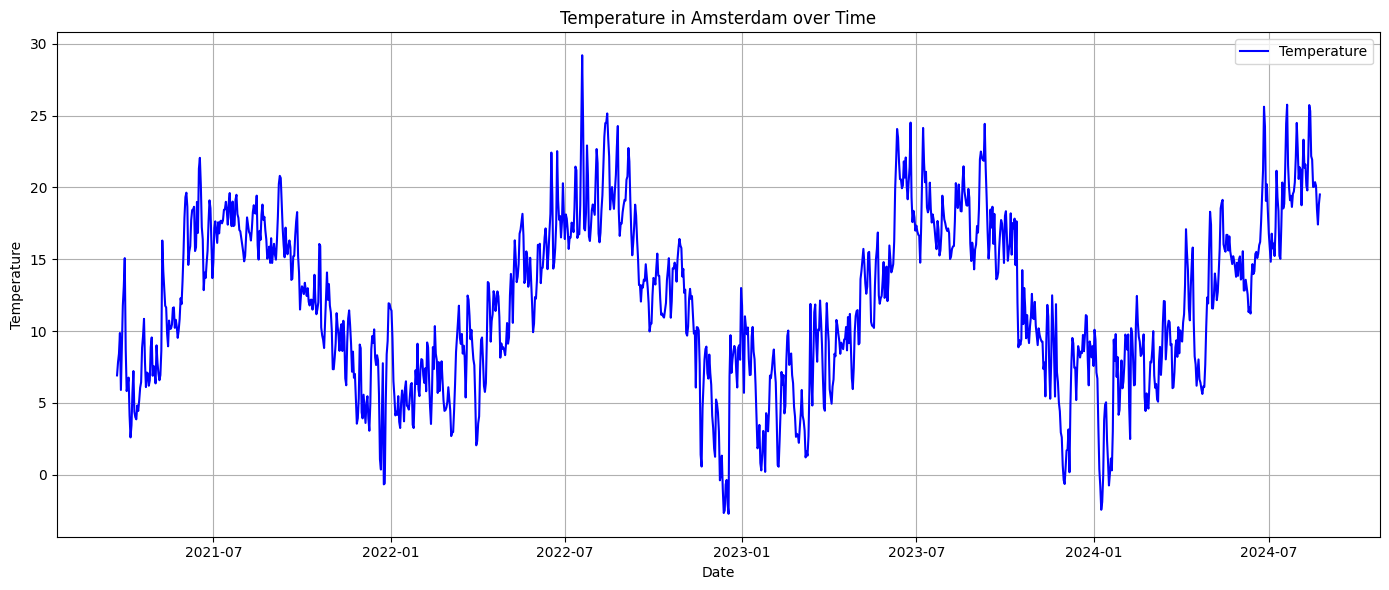

In [149]:
#Set the rolling window to 7 days
rolling_window = 14
daily_dataframe['rolling_mean'] = daily_dataframe['temperature_2m_mean'].rolling(window=rolling_window).mean()
daily_dataframe['rolling_variance'] = daily_dataframe['temperature_2m_mean'].rolling(window=rolling_window).var()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, daily_dataframe['temperature_2m_mean'], label='Temperature', color='blue')
#plt.plot(daily_dataframe.index, daily_dataframe['rolling_mean'], label=f'{rolling_window}-Day Rolling Mean', color='orange')
#plt.plot(daily_dataframe.index, daily_dataframe['rolling_variance'], label=f'{rolling_window}-Day Rolling Variance', color='green')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature in Amsterdam over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

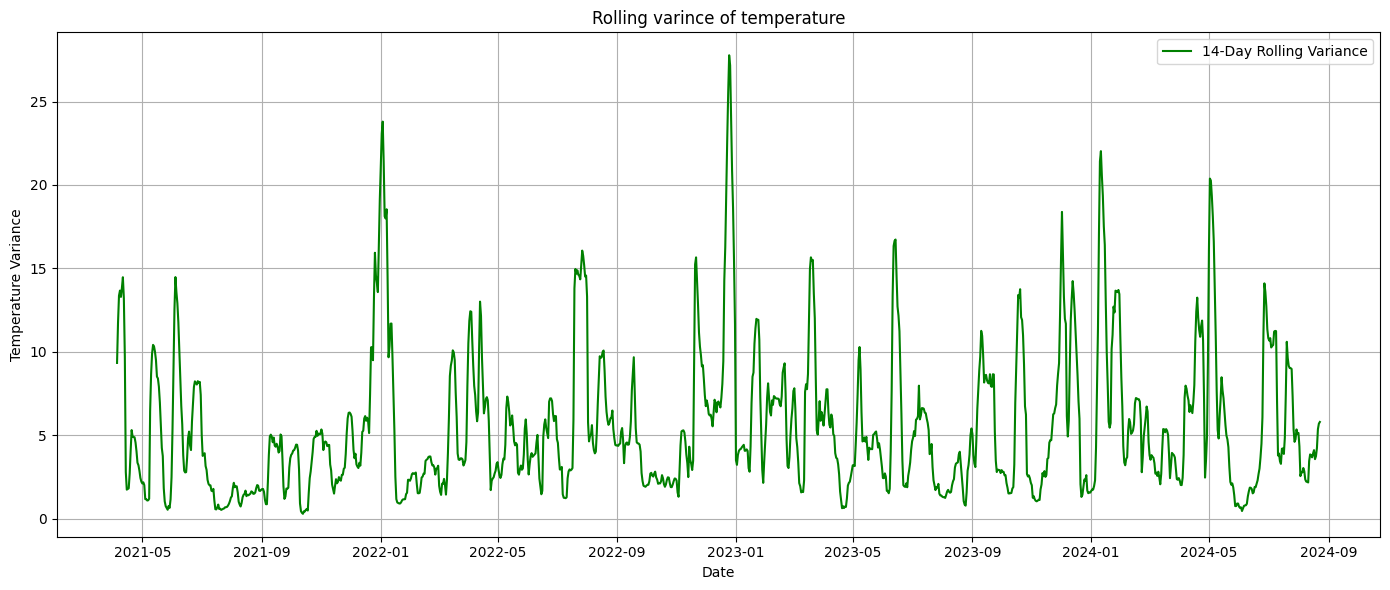

In [42]:
# Plot
plt.figure(figsize=(14, 6))
#plt.plot(daily_dataframe.index, daily_dataframe['temperature_2m_mean'], label='Temperature', color='blue')
#plt.plot(daily_dataframe.index, daily_dataframe['rolling_mean'], label=f'{rolling_window}-Day Rolling Mean', color='orange')
plt.plot(daily_dataframe.index, daily_dataframe['rolling_variance'], label=f'{rolling_window}-Day Rolling Variance', color='green')

plt.xlabel('Date')
plt.ylabel('Temperature Variance')
plt.title('Rolling varince of temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

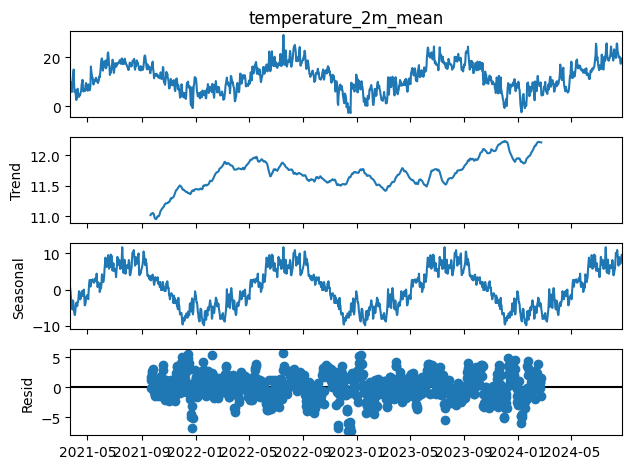

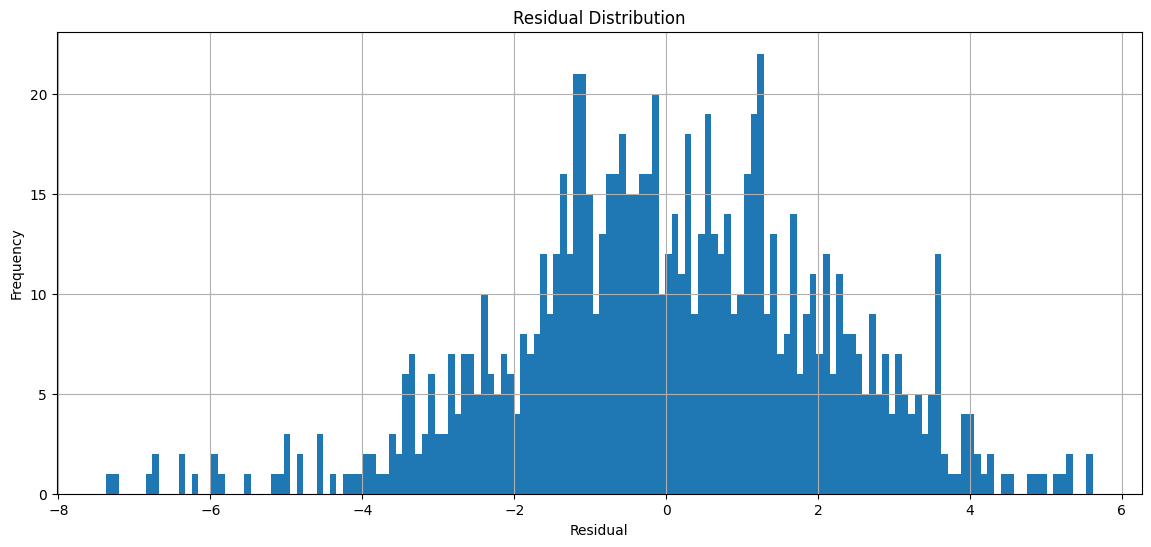

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (assume 365 days per year for annual seasonality)
decompose_result = seasonal_decompose(
    daily_dataframe['temperature_2m_mean'], 
    model='additive', 
    period=365
)

# Extract components
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Plot decomposition
plt.figure(figsize=(14, 6))
decompose_result.plot()
plt.show()

# Plot residual distribution
plt.figure(figsize=(14, 6))
plt.hist(residual.dropna(), bins=150)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

TASK 2: RESIDUAL ANALYSIS

In [56]:
residualsss = residual.dropna()

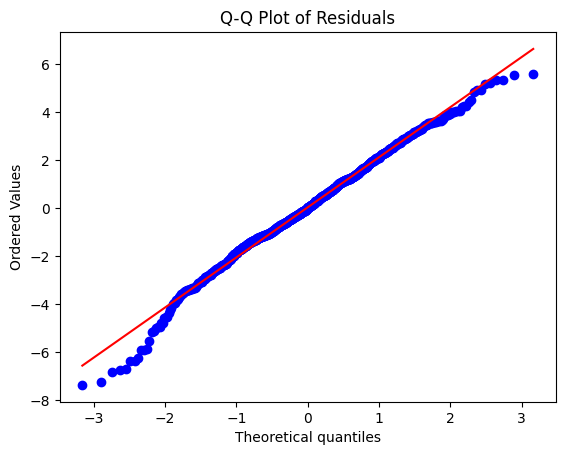

In [61]:
import scipy.stats as stats

stats.probplot(residualsss, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

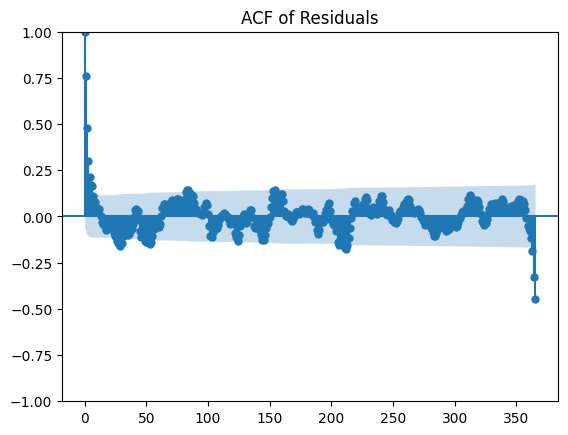

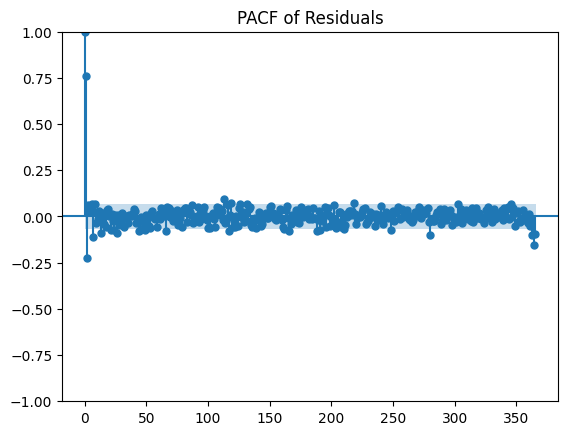

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residualsss, lags=365)
plt.title("ACF of Residuals")
plt.show()

# PACF plot
plot_pacf(residualsss, lags=365)
plt.title("PACF of Residuals")
plt.show()

In [63]:
#Dickey-Fuller test for stationarity of the residuals:

from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(residualsss)

# Extract and print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used lags:", result[2])
print("Number of observations:", result[3])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -7.935542350382913
p-value: 3.421491021964388e-12
Used lags: 7
Number of observations: 878
Critical Values:
   1%: -3.437819842246547
   5%: -2.8648374649929753
   10%: -2.5685258078777093


It follows that we reject the null--hypothesis of a unit root.

# =====================================================================================================================================

PART C: Fitting the Model under P

TASK 1: Deterministic Model Fitting

TASK 2: Autoregressive Modeling of Residuals 

??INCLUDE FOURIER APPROXIMATION??

In [68]:
from scipy.optimize import curve_fit

# Define the deterministic model function
def model_fit(x, a, b, alpha, theta):
    omega = 2 * np.pi / 365.25
    return a + b * x + alpha * np.sin(omega * x + theta)

# Convert dates to ordinal numbers and fit model
first_ord = daily_dataframe.index[0].toordinal()
xdata = np.array([date.toordinal() - first_ord for date in daily_dataframe.index])
ydata = daily_dataframe['temperature_2m_mean']

# Fit the model
params_all, cov = curve_fit(model_fit, xdata, ydata, method='lm')

# Store results
daily_dataframe['model'] = model_fit(xdata, *params_all)
daily_dataframe['residuals'] = daily_dataframe['temperature_2m_mean'] - daily_dataframe['model']

print("Estimated parameters:", params_all)

Estimated parameters: [ 1.06638907e+01  1.52371298e-03  6.96298289e+00 -6.90505160e+00]


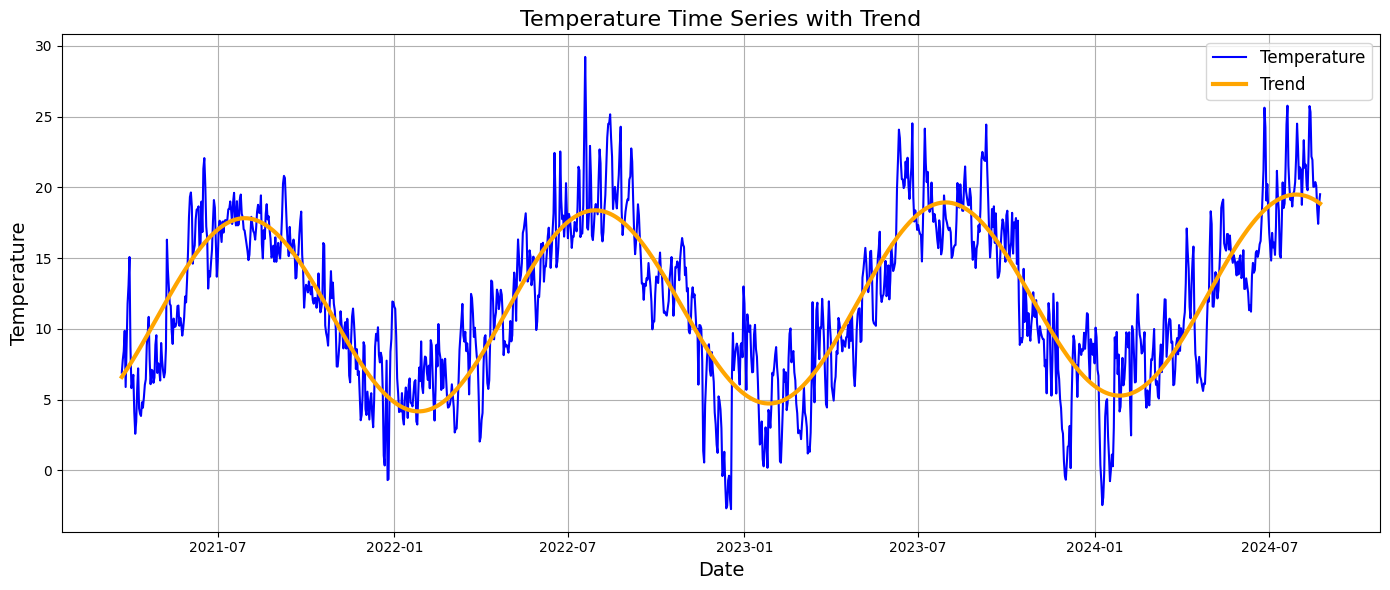

In [150]:
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, 
         daily_dataframe['temperature_2m_mean'], 
         label='Temperature', 
         color='blue')
plt.plot(daily_dataframe.index, 
         daily_dataframe['model'], 
         label='Trend', 
         color='orange',
         linewidth=3)  # Thicker line

plt.xlabel('Date', fontsize=14)  # Larger x-label
plt.ylabel('Temperature', fontsize=14)  # Larger y-label
plt.title('Temperature Time Series with Trend', fontsize=16)  # Larger title
plt.legend(fontsize=12)  # Larger legend text
plt.grid(True)
plt.tight_layout()
plt.show()

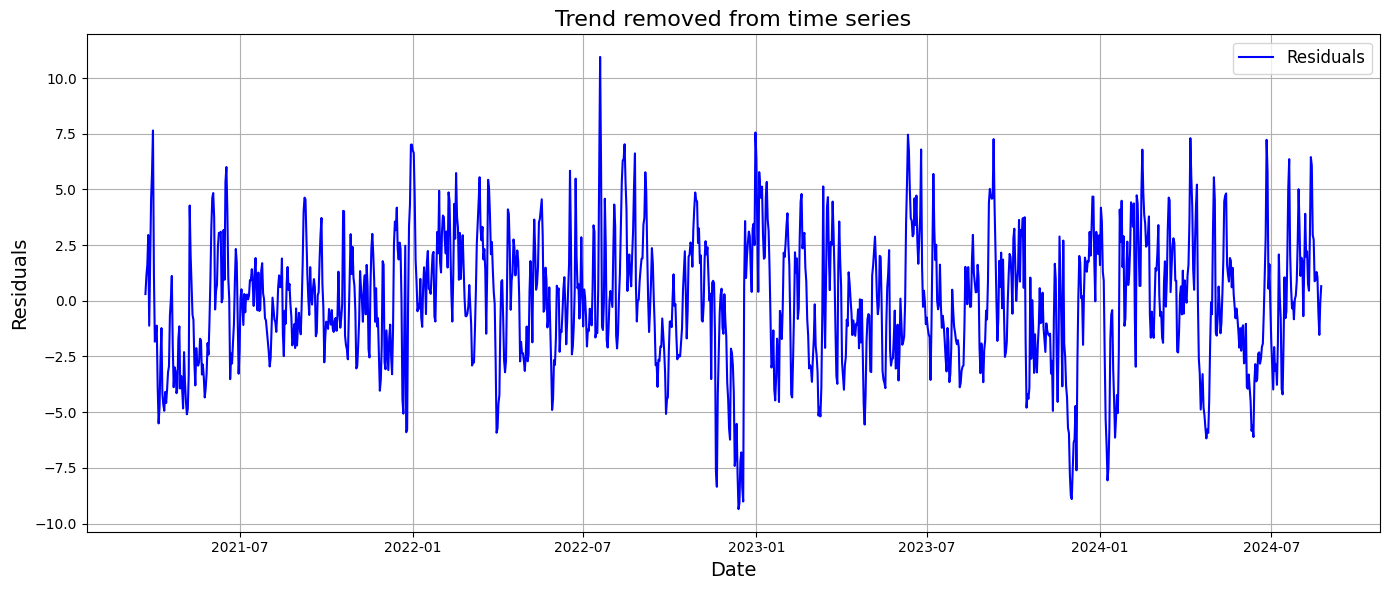

In [152]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(daily_dataframe.index, daily_dataframe['residuals'], label='Residuals', color='blue')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.title('Trend removed from time series',fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

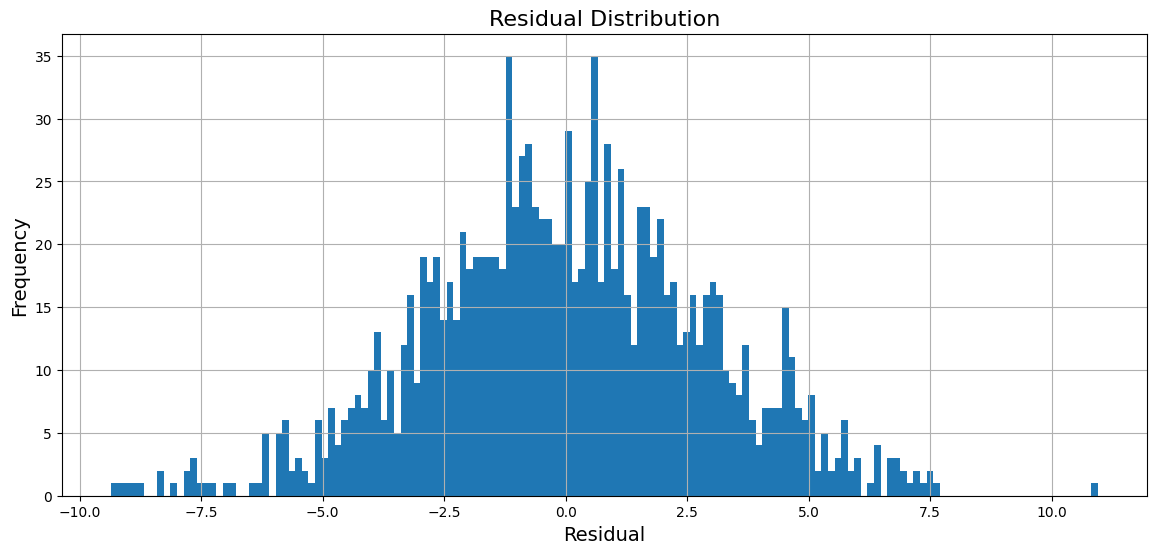

In [153]:
plt.figure(figsize=(14, 6))
plt.hist(daily_dataframe['residuals'], bins=150)
plt.title("Residual Distribution",fontsize=16)
plt.xlabel("Residual",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.grid(True)
plt.show()

In [157]:
from scipy.stats import kstest, norm
import numpy as np

# Extract residuals
residuals = daily_dataframe['residuals'].dropna()  # Ensure no NaN values

# Fit a normal distribution to the residuals (estimate mean and std)
mu, std = norm.fit(daily_dataframe['residuals'])

# Perform the KS test against a normal distribution with the same mean and std
ks_statistic, p_value = kstest(residuals, 'norm', args=(mu, std))

# Print results
print(f"Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.10  # Significance level
if p_value > alpha:
    print("Fail to reject H0: Residuals appear to follow a normal distribution.")
else:
    print("Reject H0: Residuals do NOT follow a normal distribution.")

Kolmogorov-Smirnov Test Results:
KS Statistic: 0.0155
P-value: 0.9201
Fail to reject H0: Residuals appear to follow a normal distribution.


We now fit an AR-model to the residuals. The AR order is based on the number of significant lags in the PACF.

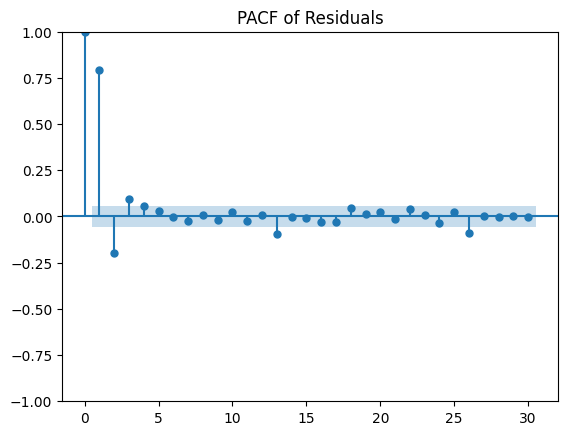

In [76]:
# PACF plot
plot_pacf(daily_dataframe['residuals'], lags=30)
plt.title("PACF of Residuals")
plt.show()

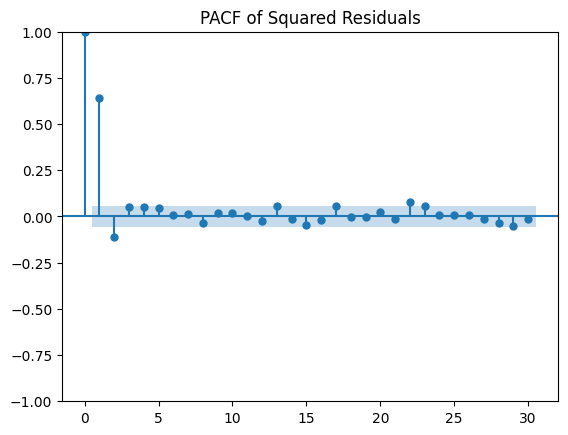

In [93]:
daily_dataframe['residuals_squared'] = (daily_dataframe['residuals'])**2

# PACF plot
plot_pacf(daily_dataframe['residuals_squared'], lags=30)
plt.title("PACF of Squared Residuals")
plt.show()

This suggests the order should be 3 or 4, we try to confirm this with the BIC:

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

#DIT LIJKT NIET ECHT TE WERKEN

bic_values = []
max_p = 25
for p in range(1, max_p + 1):
    model = AutoReg(daily_dataframe['residuals'], lags=p).fit()
    bic_values.append(model.bic)

optimal_p = np.argmin(bic_values) + 1
print(f"Optimal AR order (BIC): p = {optimal_p}")

bic_values_2 = [] 
for p in range(1, max_p + 1):
    model = AutoReg(daily_dataframe['residuals_squared'], lags=p).fit()
    bic_values_2.append(model.bic)

optimal_p_2 = np.argmin(bic_values_2) + 1
print(f"Optimal AR order (BIC): p = {optimal_p_2}")

C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

Optimal AR order (BIC): p = 14
Optimal AR order (BIC): p = 23


C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

# =====================================================================================================================

In [87]:
#estimation of mean reversion parameter kappa

#Fit an AR(1)- model to the de-trended data (in this case these are the residuals)

FFFF = AutoReg(daily_dataframe['residuals'], lags=1, trend='n').fit()
print(FFFF.summary())

                            AutoReg Model Results                             
Dep. Variable:              residuals   No. Observations:                 1250
Model:                     AutoReg(1)   Log Likelihood               -2481.859
Method:               Conditional MLE   S.D. of innovations              1.765
Date:                Sat, 10 May 2025   AIC                           4967.718
Time:                        12:58:37   BIC                           4977.978
Sample:                    03-24-2021   HQIC                          4971.575
                         - 08-23-2024                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
residuals.L1     0.7934      0.017     46.058      0.000       0.760       0.827
                                    Roots                                    
                  Real          Imaginary      

C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# it follows that the estimated parameter for kappa is given by (1- 0.7934) = 0.2066



# FOURIER MOET HIER EVT. NOG BIJ.

PART D TASK 1:

In [103]:
#simulate the paths

JJJJ = AutoReg(daily_dataframe['residuals_squared'], lags=2).fit()
JJJJ.params

C:\Users\wempe\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


const                   3.338222
residuals_squared.L1    0.711314
residuals_squared.L2   -0.108208
dtype: float64

In [105]:
daily_dataframe.tail()

,date,temperature_2m_mean,rolling_mean,rolling_variance,model,residuals,residuals_squared
date,,,,,,,
2024-08-19 00:00:00+00:00,2024-08-19 00:00:00+00:00,20.119581,21.734912,3.747316,19.040534,1.079047,1.164343
2024-08-20 00:00:00+00:00,2024-08-20 00:00:00+00:00,18.469584,21.387739,4.241981,18.997251,-0.527668,0.278434
2024-08-21 00:00:00+00:00,2024-08-21 00:00:00+00:00,17.421667,21.104554,5.365598,18.952065,-1.530398,2.342117
2024-08-22 00:00:00+00:00,2024-08-22 00:00:00+00:00,18.838331,20.906786,5.699110,18.904988,-0.066656,0.004443
2024-08-23 00:00:00+00:00,2024-08-23 00:00:00+00:00,19.513332,20.864226,5.797584,18.856034,0.657298,0.432041


In [144]:
import random 


length_of_sim = 300
initial_temp = np.array([19.513332])
simulated_temp = list(initial_temp)
time_index = np.arange(1249, 1249 + length_of_sim + 1)
squared_resid = [0.004443, 0.432041]

def trend_func(t):
    VVV = model_fit(t,*params_all)
    return VVV

for i in range(1, length_of_sim):
    if i >= len(squared_resid):
        new_resid = (JJJJ.params[0] + 
                    JJJJ.params[1] * squared_resid[i-1] + 
                    JJJJ.params[2] * (squared_resid[i-2] if i > 1 else 0))
        squared_resid.append(new_resid)
    
    trend_current = trend_func(time_index[i])
    trend_prev = trend_func(time_index[i-1])
    kappa = 1 - 0.7934
    noise = np.sqrt(squared_resid[i]) * random.normalvariate(0)
    
    new_temp = (trend_current + kappa * (simulated_temp[i-1] - trend_prev) + noise)
    simulated_temp.append(new_temp)

simulated_temp = np.array(simulated_temp)

C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\3975609517.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_resid = (JJJJ.params[0] +
C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\3975609517.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  JJJJ.params[1] * squared_resid[i-1] +
C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\3975609517.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  JJJJ.params[2] * (squared_

In [158]:
# Simulate paths

from scipy.stats import norm

# Parameters
num_paths = 1000                # Number of simulated paths
length_of_sim = 300           # Days to simulate
initial_temp = np.array([19.513332])
squared_resid = [0.004443, 0.432041]  # Initial squared residuals
kappa = 1 - 0.7934  


simulated_paths = []
for _ in range(num_paths):
    path = list(initial_temp)
    time_index = np.arange(1249, 1249 + length_of_sim + 1)
    
    for i in range(1, length_of_sim):
        # Update squared residuals (GARCH-like)
        if i >= len(squared_resid):
            new_resid = (JJJJ.params[0] + 
                        JJJJ.params[1] * squared_resid[i-1] + 
                        JJJJ.params[2] * (squared_resid[i-2] if i > 1 else 0))
            squared_resid.append(new_resid)
        
        # Simulate temperature
        trend_current = trend_func(time_index[i])
        trend_prev = trend_func(time_index[i-1])
        noise = np.sqrt(squared_resid[i]) * norm.rvs(0)  # Normal random noise
        
        new_temp = trend_current + kappa * (path[i-1] - trend_prev) + noise
        path.append(new_temp)
    
    simulated_paths.append(np.array(path))

simulated_paths = np.array(simulated_paths)


C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\2378561076.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_resid = (JJJJ.params[0] +
C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\2378561076.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  JJJJ.params[1] * squared_resid[i-1] +
C:\Users\wempe\AppData\Local\Temp\ipykernel_34252\2378561076.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  JJJJ.params[2] * (squared_

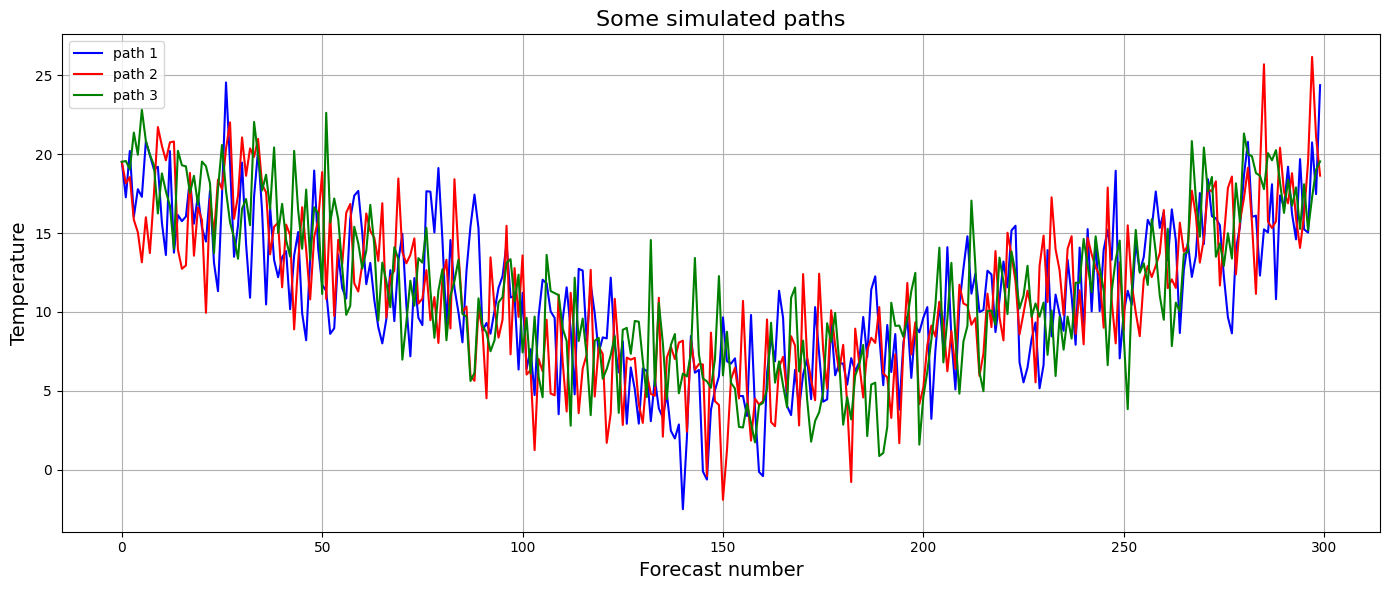

In [173]:
plt.figure(figsize=(14, 6))
plt.plot(range(0,300),simulated_paths[3,:], label='path 1', color='blue')
plt.plot(range(0,300),simulated_paths[5,:], label='path 2', color='red')
#plt.plot(range(0,300),simulated_paths[9,:], label='simulated temp', color='orange')
plt.plot(range(0,300),simulated_paths[8,:], label='path 3', color='green')
plt.xlabel('Forecast number',fontsize = 14)
plt.ylabel('Temperature',fontsize = 14)
plt.title('Some simulated paths',fontsize = 16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
N = 20                 
K = 100              
r = 0.05                
n = 60               
reference_temp = 18     

num_paths, path_length = simulated_paths.shape

hdd_paths = np.sum(np.maximum(reference_temp - simulated_paths[:, :n], 0), axis=1)
payoffs = N * np.maximum(hdd_paths - K, 0)
option_price = np.exp(-r * (n/365)) * np.mean(payoffs)

print(f"HDD Call Option Price: ${option_price:.2f}")

HDD Call Option Price: $655.62


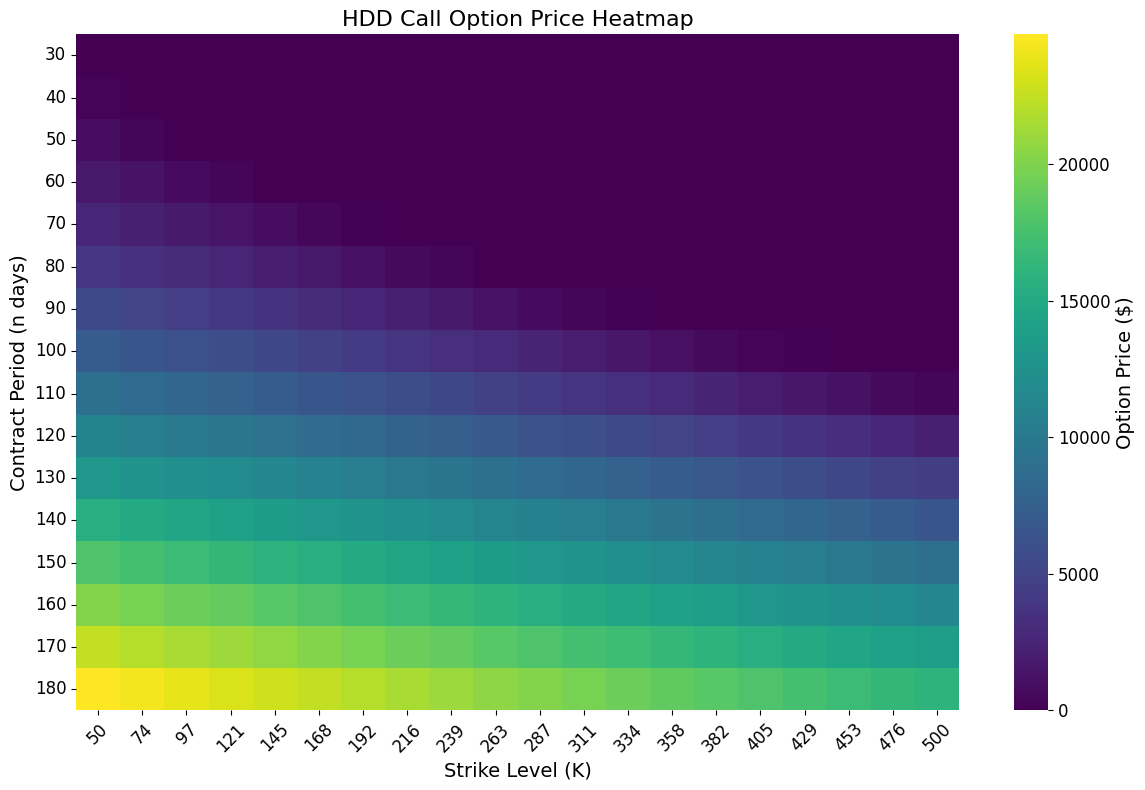

In [180]:
import seaborn as sns


# Set global font sizes
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

# Fixed parameters
N = 20
r = 0.05
reference_temp = 18
num_paths, max_path_length = simulated_paths.shape

# Create ranges for K and n
K_values = np.linspace(50, 500, 20)  # Strike levels from 50 to 500 HDDs
n_values = np.arange(30, 181, 10)     # Contract periods from 30 to 180 days

# Initialize price matrix
price_matrix = np.zeros((len(n_values), len(K_values)))

# Calculate option prices
for i, n in enumerate(n_values):
    for j, K in enumerate(K_values):
        hdd_paths = np.sum(np.maximum(reference_temp - simulated_paths[:, :n], 0), axis=1)
        payoffs = N * np.maximum(hdd_paths - K, 0)
        price_matrix[i, j] = np.exp(-r * (n/365)) * np.mean(payoffs)

# Create smooth heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(price_matrix,
                xticklabels=np.round(K_values).astype(int),
                yticklabels=n_values,
                cmap="viridis",
                annot=False,  # Removed values
                cbar_kws={'label': 'Option Price ($)'},
                rasterized=True)  # Smoother color blending

# Enhance visualization
ax.figure.axes[-1].yaxis.label.set_size(14)  # Colorbar label size
ax.collections[0].set_rasterized(True)  # Better blending

plt.title("HDD Call Option Price Heatmap", fontsize=16)
plt.xlabel("Strike Level (K)", fontsize=14)
plt.ylabel("Contract Period (n days)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

In [176]:
import seaborn as sns

In [147]:
daily_dataframe.tail()

,date,temperature_2m_mean,rolling_mean,rolling_variance,model,residuals,residuals_squared
date,,,,,,,
2024-08-19 00:00:00+00:00,2024-08-19 00:00:00+00:00,20.119581,21.734912,3.747316,19.040534,1.079047,1.164343
2024-08-20 00:00:00+00:00,2024-08-20 00:00:00+00:00,18.469584,21.387739,4.241981,18.997251,-0.527668,0.278434
2024-08-21 00:00:00+00:00,2024-08-21 00:00:00+00:00,17.421667,21.104554,5.365598,18.952065,-1.530398,2.342117
2024-08-22 00:00:00+00:00,2024-08-22 00:00:00+00:00,18.838331,20.906786,5.699110,18.904988,-0.066656,0.004443
2024-08-23 00:00:00+00:00,2024-08-23 00:00:00+00:00,19.513332,20.864226,5.797584,18.856034,0.657298,0.432041
